# Predicting House Prices

Nowadays, housing prices are extremely on the rise due to the increase in demand. It is really hard to get your hands on a house and even if you do, it has become normal to pay much more than the original sales price of the house.

When thinking about the sales price of a house, most people think this is a combination of the size of the lot, the amount of bedrooms and the location. However, many more unfamiliar features determine the sales price of a house. Given a dataset with 79 features, both a mixture of categorical and numerical features, we are going to estimate the value of houses in Ames Iowa. Creating a model which predicts housing prices will help to solve real world problems because housing prices can in this way be computed in a more rational way.

## Import the necessary modules and libraries

In [1]:
import pandas as pd 

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from math import sqrt

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


## Import data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_data_submission = pd.read_csv('sample_submission.csv')


## Inspect data

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
def show_missing_info(df):
    missing_info = df.isna().sum().reset_index(drop=False)
    missing_info.columns = ["column","rows"]
    missing_info["missing_pct"] = (missing_info["rows"]/train_data.shape[0])*100
    missing_info = missing_info[missing_info["rows"]>0].sort_values(by="missing_pct",ascending=False)
    return missing_info

missing_df = show_missing_info(train_data)
print(missing_df)

          column  rows  missing_pct
72        PoolQC  1453    99.520548
74   MiscFeature  1406    96.301370
6          Alley  1369    93.767123
73         Fence  1179    80.753425
57   FireplaceQu   690    47.260274
3    LotFrontage   259    17.739726
58    GarageType    81     5.547945
59   GarageYrBlt    81     5.547945
60  GarageFinish    81     5.547945
63    GarageQual    81     5.547945
64    GarageCond    81     5.547945
32  BsmtExposure    38     2.602740
35  BsmtFinType2    38     2.602740
33  BsmtFinType1    37     2.534247
31      BsmtCond    37     2.534247
30      BsmtQual    37     2.534247
26    MasVnrArea     8     0.547945
25    MasVnrType     8     0.547945
42    Electrical     1     0.068493


As the first 5 features ('Alley','PoolQC','Fence','MiscFeature','FireplaceQu') include a lot of missing data, we decided to drop the columns of this features from the data set.

## Visualize sale prices

/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

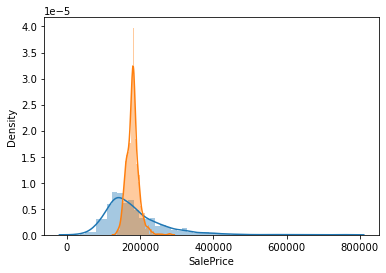

In [5]:
# select the Sale price from the training data = y 
y_train = train_data['SalePrice']

# select the Sale price from the test data = y 
y_test = test_data_submission['SalePrice']

# create histogram with seaborn of the Sale price (y) from train and test data
sns.distplot(y_train)
sns.distplot(y_test)

## Prepare data

Because it has been discovered that the test data is distributed very differently than the training data, we are going to redivide the data set. In addition, we will make some adjustments in the data set in order to make the data useful as input to the model.

1. Merge train and test data set
1. One hot encode the categorical data
2. Clean data
    - Replace missing numerical data with the mean value of that feature
    - Replace missing categorical data with the most common category of that feature)
3. Ramdomly devide merged data set into 70% train data and 30% test data

In [6]:
def cleaning(dataframe):
    """
    This function corrects any missing values in a pandas dataframe
    returns the cleaned dataframe
    """
    
    # loop through all the features/columns in the training data
    for column in dataframe:
        
        # if column is in top 5 of columns with most missing data, drop column
        if column in ['Alley','PoolQC','Fence','MiscFeature','FireplaceQu']:
            dataframe.drop[column]
        
        # check whether the data in each column is numerical
        if is_numeric_dtype(dataframe[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = dataframe[column].mean()

            # replace the missing values in this column with the mean of the column
            dataframe[column] = dataframe[column].fillna(column_mean)

        # also replace categorical missing values
        # check this approach!
        else:
            dataframe[column] = dataframe[column].fillna(dataframe[column].value_counts().index[0])
    
    return dataframe


## One hot encode categorical data

In [7]:
def one_hot_encoding(df):
    
    """One hot encode categorical data from a dataframe."""
        
    # select all categorical features
    cat_data = df.select_dtypes(include=[object])
    num_data = df.select_dtypes(exclude=[object])
    
    # create a LabelEncoder object and apply it to each categorical feature in the data
    le = preprocessing.LabelEncoder()
    cat_data_2 = cat_data.apply(le.fit_transform)
    
    # create a OneHotEncoder object and fit it to all categorical data
    enc = preprocessing.OneHotEncoder()
    enc.fit(cat_data_2)
    onehotlabels = enc.transform(cat_data_2).toarray()
    
    # get all possible categories from the data
    all_categories = enc.get_feature_names(cat_data_2.columns)

    # create new dataframe with all possible categories as columns
    cat_data = pd.DataFrame(onehotlabels, columns = all_categories)
    
    num_data = num_data.set_index('Id')
    
    # merge the numerical data with the one hot encoded categorical data again
    result = pd.concat([cat_data, num_data], axis=1).reindex(cat_data.index)
        
    return result


## Redivide the dataset

In [8]:
def shuffle_data(train_data_df, test_data_df, test_data_submission_df):
    """
    Function to randomly shuffle the train and test data
    """
    # drop the house Id, as this is already in the test_data_df
    test_data_submission_df = test_data_submission_df.drop('Id', axis=1)

    # add the saleprice (y) to the test data
    test_data_df.insert(80, "SalePrice", test_data_submission_df, True)
        
    # 'glue' the test data and train data together
    merged_df = pd.concat([train_data_df, test_data_df])
    
    # one hot encode categorical data in dataframe
    total_df = one_hot_encoding(merged_df)   
    
    # clean data in dataframe
    total_df = cleaning(total_df)
        
    # create SalePrice list
    y = total_df['SalePrice'].tolist()

    # remove the Saleprice from the total dataframe 
    X = total_df.drop('SalePrice', axis=1)

    # split between test data and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = shuffle_data(train_data, test_data, test_data_submission)


/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Visualize sale prices

/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

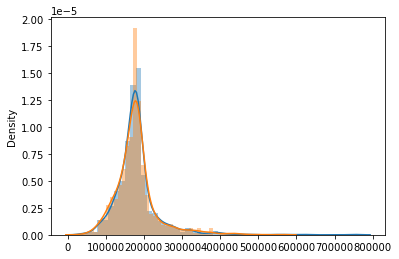

In [9]:
# create histogram with seaborn of the Sale price (y) from train and test data
sns.distplot(y_train)
sns.distplot(y_test)

## Regression tree

* Have a look at possible parameters!!!! https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [10]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=5, splitter="best")
regr_1.fit(X_train, y_train)

# Predict
y_pred1 = regr_1.predict(X_test)

# Compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred1, y_test))
print("RMSE:", rmse)

# Visualize the Decision Tree
text_representation = tree.export_text(regr_1)
print(text_representation)


RMSE: 50052.755786053145
|--- feature_278 <= 7.50
|   |--- feature_290 <= 1416.50
|   |   |--- feature_287 <= 1080.50
|   |   |   |--- feature_290 <= 790.50
|   |   |   |   |--- feature_192 <= 0.50
|   |   |   |   |   |--- value: [103397.57]
|   |   |   |   |--- feature_192 >  0.50
|   |   |   |   |   |--- value: [164954.43]
|   |   |   |--- feature_290 >  790.50
|   |   |   |   |--- feature_278 <= 4.50
|   |   |   |   |   |--- value: [133676.46]
|   |   |   |   |--- feature_278 >  4.50
|   |   |   |   |   |--- value: [150635.25]
|   |   |--- feature_287 >  1080.50
|   |   |   |--- feature_286 <= 1150.00
|   |   |   |   |--- feature_277 <= 9241.00
|   |   |   |   |   |--- value: [148060.96]
|   |   |   |   |--- feature_277 >  9241.00
|   |   |   |   |   |--- value: [166548.24]
|   |   |   |--- feature_286 >  1150.00
|   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |--- value: [173763.21]
|   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |--- value: [118800.00]
|   |-

### Determine the optimal max_depth

Optimal max_depth = 4
Optimal RMSE = 46023.80343232945


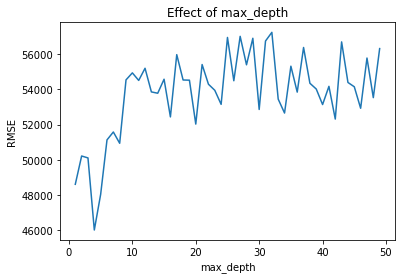

In [11]:
model = DecisionTreeRegressor()
estimators = np.arange(1, 50)
rmses = []
optimal_rmse = float("inf")
optimal_max_depth = 0

for n in estimators:
    
    # Fit regression model
    model.set_params(max_depth=n)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute root mean squared error 
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmses.append(rmse)
    
    if rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_max_depth = n
        
    
plt.title("Effect of max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.plot(estimators, rmses)

print(f"Optimal max_depth =", optimal_max_depth)
print(f"Optimal RMSE =", optimal_rmse)


## Random forest regression

In [12]:
regressor = RandomForestRegressor(n_estimators=140, random_state=0)
regressor.fit(X_train.values, y_train)

y_pred = regressor.predict(X_test)

# compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:", rmse)


RMSE: 37507.10089813428


/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### Determine the optimal number of estimators

Optimal n_estimators = 80
Optimal RMSE = 37484.16963940001


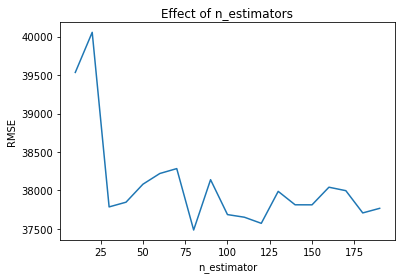

In [13]:
model = RandomForestRegressor()
estimators = np.arange(10, 200, 10)
rmses = []
optimal_rmse = float("inf")
optimal_n_estimators = 0

for n in estimators:
    
    # Fit regression model
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute root mean squared error 
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmses.append(rmse)
    
    if rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_n_estimators = n
    
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("RMSE")
plt.plot(estimators, rmses)

print(f"Optimal n_estimators =", optimal_n_estimators)
print(f"Optimal RMSE =", optimal_rmse)